In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.metrics import median_absolute_error
from CAMUS import CAMUS_score, CAMUS_estimate_acc, precluster_scRNA_scST

import warnings
warnings.filterwarnings("ignore")

## 1. We first load the annotated adata (collected from the retina of chick)

In [2]:
adata_raw = sc.read_h5ad('../data/Chick_P10_annotated.h5ad')

We have the maual annotation in 'cell_ontology_class' and the annotation results from different reference-method pairs stored from index 15 to 169 (155 reference-method pairs total), e.g., 'zebrafish_LD_4hr_CAME' means the reference data is 'zebrafish_LD_4hr' while the annotation method is 'CAME'.

## 2. We then preprocess the data and then performed pre-clustering

For the scRNA-seq or scST datasets, we used 'precluster_scRNA_scST' function.

In [3]:
adata = precluster_scRNA_scST(adata_raw.copy(), resolution=0.4)

## 3. We next estimate the annotation accuracy by 'CAMUS_estimate_acc' function

annot_key means we would like to estimate the accuracy of annotation results for this case (e.g. annot_key='zebrafish_LD_4hr_CAME' means reference='zebrafish_LD_4hr', method='CAME) which stored in the adata.obs columns.

Here, we estimated the annotation accuracy of total 155 reference-method pairs. The trained model can be downloaded from here[https://drive.google.com/drive/folders/1PvSwKWwDtFXUV5ghhzs9mIkNljQLqxrA?dmr=1&ec=wgc-drive-globalnav-goto].

In [4]:
actual_acc_list = []# Store the actual accuracy
estimated_acc_list = []# Store the estimated accuracy
for annot_key in tqdm_notebook(adata.obs.columns[15:169]):
    # Calculate the actual accuracy
    actual_acc = np.mean(adata.obs['cell_ontology_class'].astype(str) == adata.obs[annot_key].astype(str))
    # Calculate the estimated accuracy
    estimated_acc = CAMUS_estimate_acc(adata, annot_key=annot_key, data_type='scRNA-seq', model_path='ag-20240806_143724')[0]
    actual_acc_list.append(actual_acc)
    estimated_acc_list.append(estimated_acc)
MAE = median_absolute_error(actual_acc_list,estimated_acc_list)
print(f'Median Absolute Error: {MAE}')

  0%|          | 0/154 [00:00<?, ?it/s]

Median Absolute Error: 0.052929730368416195


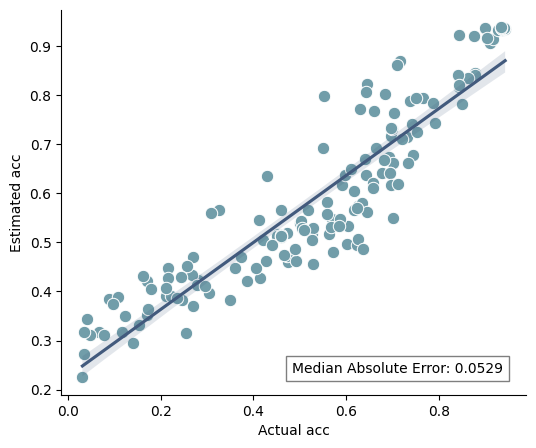

In [5]:
# Create a figure
plt.figure(figsize=(6, 5))

# Create a scatter plot
sns.scatterplot(actual_acc_list, estimated_acc_list, s=80, color='#719da9')

# Add a regression line
sns.regplot(x=actual_acc_list, y=estimated_acc_list, scatter=False, line_kws={'color': '#425a7d'})

# Add Median Absolute Error text to the plot
plt.text(0.95, 0.05, f'Median Absolute Error: {MAE:.4f}',
         ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Hide the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels and title
plt.xlabel('Actual acc')
plt.ylabel('Estimated acc')
plt.show()